In [52]:
#Important libraries
import os
import sys
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.patches as mpatches
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
#Import Dataset
train_df = pd.read_csv('train.tsv', delimiter='\t', header = None)
valid_df = pd.read_csv('valid.tsv', delimiter='\t', header = None)
test_df = pd.read_csv('test.tsv', delimiter='\t', header = None)

In [54]:
#Load dataset
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [55]:
#Parameters Settings
def map_f(x):
    '''
    Mapping the label column.
    
    The function maps 'mostly-true' and 'true' from the label column to 0 
    and rest to 1. This creates a classification target as required for 
    the problem.
    
    Parameters
    ----------
    x : Variable from pandas Series
    
    Returns
    -------
    None
    '''
    if x=='mostly-true' or x == 'true':
        return 0
    else:
        return 1
    
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()

train['text'] = train_df[2]
train['label'] = train_df[1].apply(map_f)

valid['text'] = valid_df[2]
valid['label'] = valid_df[1].apply(map_f)

test['text'] = train_df[2]
test['label'] = test_df[1].apply(map_f)


In [56]:
#Check Length
len(train), len(valid), len(test)

(10240, 1284, 10240)

In [57]:
#Merge Data colums
X_train = pd.concat([train, valid])['text']
Y_train = pd.concat([train, valid])['label']
X_test = test['text']
Y_test = test['label']

C:\Users\ghussain\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of real and fake news')

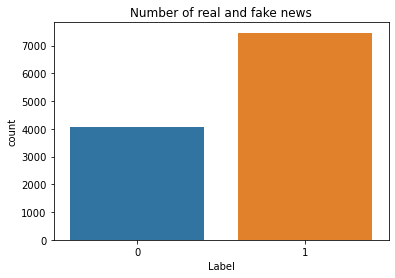

In [58]:
#Graphical Presentation
sns.countplot(Y_train)
plt.xlabel('Label')
plt.title('Number of real and fake news')

In [59]:
#Parameters
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [60]:
#Define LSTM Model
def LSTM_model():
    '''
    Builds the LSTM Network.
    
    The function builds LSTM network by taking word embeddings as input and
    using LSTM, Dense, Dropout, Dense layer in the specified order. 'ReLU'
    is used as activation function in the network and 'sigmoid' is used as
    activation function for the classification layer.
    
    Parameters
    ----------
    None
    '''
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [61]:
#Check Parameters
model = LSTM_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [62]:
#Experiment
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,validation_split=0.2)

Epoch 1/20
73/73 [==============================] - 3s 24ms/step - loss: 0.6491 - accuracy: 0.6397 - val_loss: 0.7014 - val_accuracy: 0.6642
Epoch 2/20
73/73 [==============================] - 1s 18ms/step - loss: 0.6178 - accuracy: 0.6610 - val_loss: 0.6173 - val_accuracy: 0.6711
Epoch 3/20
73/73 [==============================] - 1s 18ms/step - loss: 0.5979 - accuracy: 0.6822 - val_loss: 0.6648 - val_accuracy: 0.6681
Epoch 4/20
73/73 [==============================] - 1s 18ms/step - loss: 0.5856 - accuracy: 0.6966 - val_loss: 0.6238 - val_accuracy: 0.6529
Epoch 5/20
73/73 [==============================] - 1s 18ms/step - loss: 0.5767 - accuracy: 0.7027 - val_loss: 0.6308 - val_accuracy: 0.6521
Epoch 6/20
73/73 [==============================] - 1s 18ms/step - loss: 0.5659 - accuracy: 0.7145 - val_loss: 0.6264 - val_accuracy: 0.6607
Epoch 7/20
73/73 [==============================] - 1s 18ms/step - loss: 0.5549 - accuracy: 0.7212 - val_loss: 0.7014 - val_accuracy: 0.5892
Epoch 8/20
73

In [63]:
#Results 
X_test = X_test[:1267]
Y_test = Y_test[:1267]

In [64]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [65]:
y_pred = model.predict(test_sequences_matrix)
y_pred = y_pred.argmax(axis=-1)

In [66]:
#Accuracy,F1 Score
from sklearn.metrics import classification_report
print(classification_report(Y_test.fillna(0), y_pred))

              precision    recall  f1-score   support

         0.0       0.35      1.00      0.52       449
         1.0       0.00      0.00      0.00       818

    accuracy                           0.35      1267
   macro avg       0.18      0.50      0.26      1267
weighted avg       0.13      0.35      0.19      1267



C:\Users\ghussain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ghussain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ghussain\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
#Good**Luck